# Forecasting and Data Exploration in Python/Jupyter

## Table of Contents
1. [Introduction](#introduction)
2. [Data Exploration](#data_exploration)<br>
   2.1. [Holiday_Flag and Weekly_Sales](#holiday_sales)<br>
   2.2. [Temperature and Weekly_Sales](#temp_sales)<br>
   2.3. [Fuel_Price and Weekly_Sales](#fuel_sales)<br>
   2.4. [CPI and Weekly_Sales](#cpi_sales)<br>
   2.5. [Uemployment and Weekly_Sales](#unemp_sales)<br>
   2.6. [Summary of Exploration](#sum_explor)
3. [Defining Mean Absolute Percent Deviation for Forecasts](#mapd_def)
4. [Simple Moving Average](#sma)<br>
   4.1. [Define Simple Moving Average Function](#def_sma)<br>
   4.2. [Simple Moving Average Forecast for Weeks 107 to 111](#sma_forecast)
5. [Weighted Moving Average](#wma)<br>
   5.1. [Define Weighted Moving Average Function](#def_wma)<br>
   5.2. [Weighted Moving Average Forecast for Weeks 107 to 111](#wma_forecast)
6. [Exponential Smoothing](#es)<br>
   6.1. [Define Exponential Smoothing Function](#def_es)<br>
   6.2. [Exponential Smoothing Forecasts for Weeks 107 to 111](#es_forecast)
7. [Adjusted Exponential Smoothing](#adj_es)<br>
   7.1. [Define a Formula for Adjusted Exponential Smoothing Function](#def_adj_es)<br>
   7.2. [Adjusted Exponential Smoothing Forecast for Weeks 107 to 111](#adj_es_forecast)
8. [Summary](#sum)

## 1. Introduction <a name="introduction"></a>

Much of data analysis in business and in other disiplines go beyond using Microsoft Excel and its limitations by employing a programming language such as Python or R. As Python is a general purpose programming language it enjoys an audience well beyond the domain of data science, making it more appealing for those who wish to possibly use it for more than data science activities.<br>

In this notebook we will explore some sales data from Walmart. The source of our data is from kaggle.com. During the exploration process we will look at sales data and how some of the variables/features might be related.<br>

After the data exploration process is finished we will proceed to employ some simple and well known forecast techniques used in business including simple moving average, weighted moving average, exponential smoothing and adjusted exponential smoothing. The different techniques will then be compared to each other using mean absolute percentage deviation (MAPE).

In [1]:
#import the libraries we will use
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from fractions import Fraction
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller

#set the format of numbers to 2 decimal places
pd.options.display.float_format = '{:.2f}'.format 

In [2]:
#read the csv file into a dataframe object called data
data = pd.read_csv('Walmart_Store_sales.csv', parse_dates = [1])

#show the last bit of data to get an idea of how many entries and stores there are
data.tail()

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
6430,45,2012-09-28,713173.95,0,64.88,4.00,192.01,8.68
6431,45,2012-05-10,733455.07,0,64.89,3.98,192.17,8.67
6432,45,2012-12-10,734464.36,0,54.47,4.00,192.33,8.67
6433,45,2012-10-19,718125.53,0,56.47,3.97,192.33,8.67
6434,45,2012-10-26,760281.43,0,58.85,3.88,192.31,8.67


There are 45 stores in total. To keep this notebook short and to focus on the analysis process we will just focus on store # 1. If any other store forecast is required the analysis could easily be repeated for that store.

In [3]:
#check if there are any missing values
data.isna().any().any()

False

Above we have imported the necessary libraries, imported the csv file for walmart sales data, viewed the last values of the data and did a check to see if there are any missing values--there are no missing values in this data set.

In [4]:
#For simplicity we will only use store 1 data. In reality we would explore data and apply models to all
# stores, but for this project we will just look at store #1 to save time.
store_one= data.loc[data['Store'] == 1]
store_one.head(150)

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
0,1,2010-05-02,1643690.90,0,42.31,2.57,211.10,8.11
1,1,2010-12-02,1641957.44,1,38.51,2.55,211.24,8.11
2,1,2010-02-19,1611968.17,0,39.93,2.51,211.29,8.11
3,1,2010-02-26,1409727.59,0,46.63,2.56,211.32,8.11
4,1,2010-05-03,1554806.68,0,46.50,2.62,211.35,8.11
...,...,...,...,...,...,...,...,...
138,1,2012-09-28,1437059.26,0,76.08,3.67,222.98,6.91
139,1,2012-05-10,1670785.97,0,68.55,3.62,223.18,6.57
140,1,2012-12-10,1573072.81,0,62.99,3.60,223.38,6.57
141,1,2012-10-19,1508068.77,0,67.97,3.59,223.43,6.57


## 2. Data Exploration<a name='data_exploration'></a>

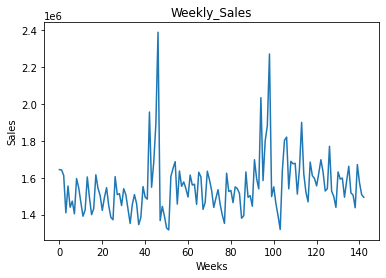

In [5]:
#Plot weekly sales to find a seasonal period
weekly_sales = list(store_one["Weekly_Sales"])
plt.plot(weekly_sales);
plt.title('Weekly_Sales')
plt.ylabel("Sales")
plt.xlabel("Weeks");

The seasonal cycle occurs about every 52 weeks (i.e. yearly).

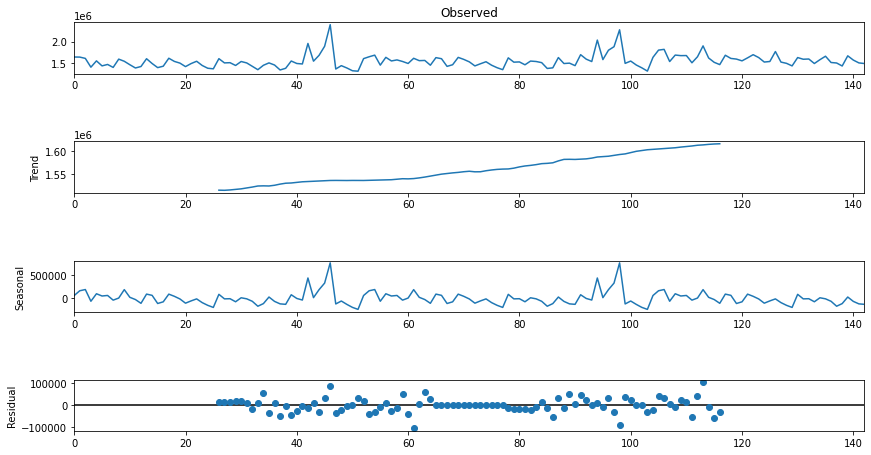

In [6]:
#Decompose the data into observed, trend, seasonal and residual components
def seasonal_decompose(weekly_sales):
    decomposition = sm.tsa.seasonal_decompose(weekly_sales, model = 'additive', period = 52 )
    fig = decomposition.plot()
    fig.set_size_inches(14, 7)
    plt.show()
    
seasonal_decompose(weekly_sales)    

### 2.1. Holiday_Flag and Weekly_Sales:<a name='holiday_sales'></a>

In [7]:
store_one[['Holiday_Flag', 'Weekly_Sales']].corr()

,Holiday_Flag,Weekly_Sales
Holiday_Flag,1.00,0.19
Weekly_Sales,0.19,1.00


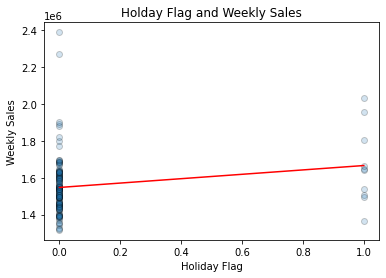

In [8]:
#Plot scatterplot with trendline.
plt.scatter(store_one[['Holiday_Flag']], store_one[['Weekly_Sales']],alpha = 0.2, edgecolor = 'black')
plt.title('Holday Flag and Weekly Sales')
plt.xlabel('Holiday Flag')
plt.ylabel('Weekly Sales')
x = store_one['Holiday_Flag'].values
y = store_one['Weekly_Sales'].values
coeff = np.polyfit(x, y, 1)
m = coeff[0]
b = coeff[1]
holiday_trend = np.linspace(0, 1, 100)
sales_trend = m * holiday_trend + b
plt.plot(holiday_trend, sales_trend, 'r-');

The correlation between the `Holiday_Flag` and `Weekly_Sales` is about 0.19, which indicates a weak positive correlation.  

### 2.2. Temperature and Weekly_Sales:<a name='temp_sales'></a>

In [9]:
store_one[['Temperature', 'Weekly_Sales']].corr()

,Temperature,Weekly_Sales
Temperature,1.00,-0.22
Weekly_Sales,-0.22,1.00


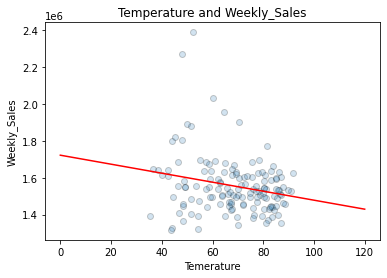

In [10]:
plt.scatter(store_one[['Temperature']], store_one[['Weekly_Sales']], alpha = 0.2, edgecolor = 'black')
plt.title('Temperature and Weekly_Sales')
plt.xlabel('Temerature')
plt.ylabel('Weekly_Sales')
x = store_one['Temperature'].values
y = store_one['Weekly_Sales'].values
coeff = np.polyfit(x, y, 1)
m = coeff[0]
b = coeff[1]
temp_trend = np.linspace(0, 120, 100)
sales_trend = m * temp_trend + b
plt.plot(temp_trend, sales_trend, 'r-');

The correlation coefficent between `Temperature` and `Weekly_Sales` is about -0.22 which is a weak negative correlation.

### 2.3. Fuel_Price and Weekly_Sales:<a name='fuel_sales'></a>

In [11]:
store_one[['Fuel_Price', "Weekly_Sales"]].corr()

,Fuel_Price,Weekly_Sales
Fuel_Price,1.00,0.12
Weekly_Sales,0.12,1.00


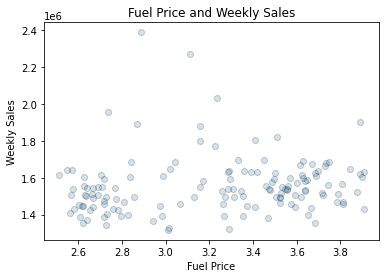

In [12]:
plt.scatter(store_one[['Fuel_Price']],store_one[['Weekly_Sales']], alpha = 0.2, edgecolor = 'black')
plt.title("Fuel Price and Weekly Sales")
plt.xlabel("Fuel Price")
plt.ylabel("Weekly Sales");

The correlation coefficient between `Fuel_Price` and `Weekly_Sales` is about 0.12 which is a very weak positive correlation.

### 2.4. CPI and Weekly_Sales:<a name='cpi_sales'></a>

In [13]:
store_one[['CPI', 'Weekly_Sales']].corr()

,CPI,Weekly_Sales
CPI,1.00,0.23
Weekly_Sales,0.23,1.00


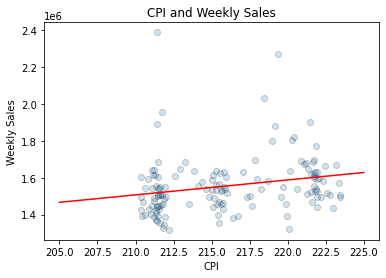

In [14]:
#Plot scatterplot with trendline
plt.scatter(store_one[['CPI']], store_one[['Weekly_Sales']], alpha = 0.2, edgecolor = 'black')
plt.title("CPI and Weekly Sales")
plt.xlabel('CPI')
plt.ylabel('Weekly Sales')
x = store_one['CPI'].values
y = store_one['Weekly_Sales'].values
coeff = np.polyfit(x, y, 1)
m = coeff[0]
b = coeff[1]
CPI_trend = np.linspace(205, 225, 100)
Sales_trend = m * CPI_trend + b
plt.plot(CPI_trend, Sales_trend, 'r-');

The correlation coefficient between `CPI` and `Weekly_Sales` is about 0.23, indicating a weak positive correlation.

### 2.5. Unemployment and Weekly_Sales:<a name='unemp_sales'></a>

In [15]:
store_one[['Unemployment', 'Weekly_Sales']].corr()

,Unemployment,Weekly_Sales
Unemployment,1.00,-0.10
Weekly_Sales,-0.10,1.00


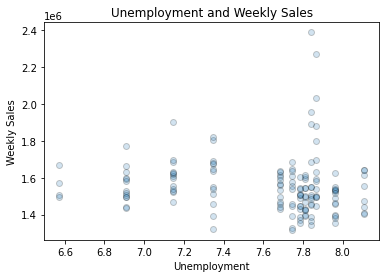

In [16]:
plt.scatter(store_one[['Unemployment']], store_one[['Weekly_Sales']], alpha = 0.2, edgecolor = 'black')
plt.title("Unemployment and Weekly Sales")
plt.xlabel('Unemployment')
plt.ylabel('Weekly Sales');

The correlation coefficient between `Unemployment` and `Weekly_Sales` is about -0.10 which is a very weak negative correlation. 

## 2.6. Summary of Exploration<a name='sum_explor'></a>

The variables that are most postively correlated with `Weekly_Sales` are the `Holiday_Flag`, and `CPI`. The variable that is most negatively correlated with `Weekly_Sales` is `Temperature`. All variables are weakly correlated. 

## 3. Defining Mean Absolute Percent Deviation for Forecasts<a name='mapd_def'></a>

In [17]:
def mapd(demand, forecast):
    abs_sum_list = []
    for demand_value, forecast_value in zip(demand, forecast):
        abs_sum_list.append(abs(demand_value - forecast_value))
    return sum(abs_sum_list) / sum(demand)

## 4. Simple Moving Average<a name='sma'></a>

In order to calculate the moving average we must select what duration we want to use. For this project we will use the previous 3 weeks to calculate the next week in the training store_one. This method of forecasting is the simpliest of all methods and simply takes the sum of the previous 3 weeks and divides by 3, which is the number of weeks. 

In [18]:
store_one.head(107)

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
0,1,2010-05-02,1643690.90,0,42.31,2.57,211.10,8.11
1,1,2010-12-02,1641957.44,1,38.51,2.55,211.24,8.11
2,1,2010-02-19,1611968.17,0,39.93,2.51,211.29,8.11
3,1,2010-02-26,1409727.59,0,46.63,2.56,211.32,8.11
4,1,2010-05-03,1554806.68,0,46.50,2.62,211.35,8.11
...,...,...,...,...,...,...,...,...
102,1,2012-01-20,1394393.84,0,54.11,3.27,219.99,7.35
103,1,2012-01-27,1319325.59,0,54.26,3.29,220.08,7.35
104,1,2012-03-02,1636339.65,0,56.55,3.36,220.17,7.35
105,1,2012-10-02,1802477.43,1,48.02,3.41,220.27,7.35


### 4.1. Define Simple Moving Average Function:<a name='def_sma'></a>

In [19]:
def sma(week_1_sales, week_2_sales, week_3_sales):
    sum_sales = sum([week_1_sales, week_2_sales, week_3_sales])
    return sum_sales / 3

### 4.2. Simple Moving Average Forecast for Weeks 107 to 111:<a name='sma_forecast'></a>

In [20]:
week_104_sales = store_one.iloc[104]['Weekly_Sales']
week_105_sales = store_one.iloc[105]['Weekly_Sales']
week_106_sales = store_one.iloc[106]['Weekly_Sales']
sma_week_107_sales = sma(week_104_sales, week_105_sales, week_106_sales)
print(sma_week_107_sales)

1752895.6933333334


In [21]:
week_107_sales = store_one.iloc[107]['Weekly_Sales']
print(week_107_sales)

1539387.83


In [22]:
sma_week_108_sales = sma(week_105_sales, week_106_sales, week_107_sales)
print(sma_week_108_sales)

1720578.42


In [23]:
week_108_sales = store_one.iloc[108]['Weekly_Sales']
print(week_108_sales)

1688420.76


In [24]:
sma_week_109_sales = sma(week_106_sales, week_107_sales, week_108_sales)
print(sma_week_109_sales)

1682559.53


In [25]:
week_109_sales = store_one.iloc[109]["Weekly_Sales"]
print(week_109_sales)

1675431.16


In [26]:
sma_week_110_sales = sma(week_107_sales, week_108_sales, week_109_sales)
print(sma_week_110_sales)

1634413.25


In [27]:
week_110_sales = store_one.iloc[110]["Weekly_Sales"]
print(week_110_sales)

1677472.78


In [28]:
sma_week_111_sales = sma(week_108_sales, week_109_sales, week_110_sales)
print(sma_week_111_sales)

1680441.5666666667


In [29]:
week_111_sales = store_one.iloc[111]["Weekly_Sales"]
print(week_111_sales)

1511068.07


In [30]:
sma_val = [sma_week_107_sales, sma_week_108_sales, sma_week_109_sales, sma_week_110_sales,
            sma_week_111_sales]
true_val = [week_107_sales, week_108_sales, week_109_sales, week_110_sales, week_111_sales]

In [31]:
sma_mapd = mapd(true_val, sma_val)
print(sma_mapd)

0.05749376348637034


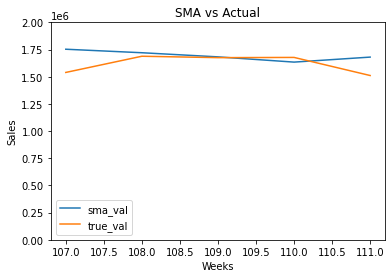

In [32]:
weeks = [107, 108, 109, 110, 111]
plt.plot(weeks, sma_val)
plt.plot(weeks, true_val)
plt.ylim(0, 2000000)
plt.title('SMA vs Actual')
plt.xlabel('Weeks')
plt.ylabel('Sales')
plt.legend(['sma_val', 'true_val']);

The mean absolute percent deviation for simple moving average forecastng over weeks 7-11 is about 5.7%. This is not too bad considering how simple the method is. 

## 5. Weighted Moving Average<a name='wma'></a>

For weighted moving average we will define a function for forecasting and like the simple moving average we will be consistent in order to compare methods by forecasting over the same period, i.e. weeks 107 through 111.

### 5.1. Define Weighted Moving Average Function:<a name='def_wma'></a>

In [33]:
def wma(week_1_sales, week_2_sales, week_3_sales):
    return sum([Fraction(3, 12) * week_1_sales, Fraction(4, 12) * week_2_sales, 
                Fraction(5, 12) * week_3_sales])

### 5.2. Weighted Moving Average Forecast for Weeks 107 to 111:<a name='wma_forecast'></a>

In [34]:
wma_week_107_sales = wma(week_104_sales, week_105_sales, week_106_sales)
print(wma_week_107_sales)

1768189.8891666667


In [35]:
wma_week_108_sales = wma(week_105_sales, week_106_sales, week_107_sales)
print(wma_week_108_sales)

1698654.2866666666


In [36]:
wma_week_109_sales = wma(week_106_sales, week_107_sales, week_108_sales)
print(wma_week_109_sales)

1671605.4266666668


In [37]:
wma_week_110_sales = wma(week_107_sales, week_108_sales, week_109_sales)
print(wma_week_110_sales)

1645750.1941666666


In [38]:
wma_week_111_sales = wma(week_108_sales, week_109_sales, week_110_sales)
print(wma_week_111_sales)

1679529.2349999999


In [39]:
wma_val = [wma_week_107_sales, wma_week_108_sales, wma_week_109_sales, wma_week_110_sales,
            wma_week_111_sales]

In [40]:
wma_mapd = mapd(true_val, wma_val)
print(wma_mapd)

0.054752481796157396


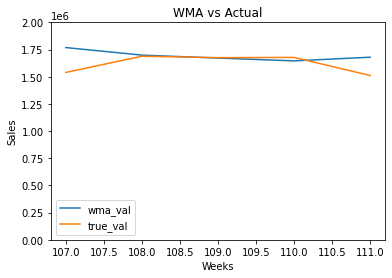

In [41]:
weeks = [107, 108, 109, 110, 111]
plt.plot(weeks, wma_val)
plt.plot(weeks, true_val)
plt.ylim(0, 2000000)
plt.title('WMA vs Actual')
plt.xlabel('Weeks')
plt.ylabel('Sales')
plt.legend(['wma_val', 'true_val']);

The weighted moving average with weights of 3/12, 4/12, and 5/12 bring an mean absolute percent deviation of about 5.5%, which is slightly better than the simple moving average at 5.7%. The weights may be further adjusted to perhaps better fit the data.  

## 6. Exponential Smoothing<a name='es'></a>

As with simple moving average and adjusted moving average forecasts we will also forecast for weeks 107 to 111 with exponential smoothing for easy comparision. The smoothing constant will be 0.5. 

### 6.1. Define Exponential Smoothing Function:<a name='def_es'></a>

In [42]:
def es(week_1_sales, forecast_1_sales):
    return 0.5* week_1_sales + 0.5 * forecast_1_sales

### 6.2. Exponential Smoothing Forecasts for Weeks 107 to 111:<a name='es_forecast'></a>

In [43]:
es_week_107_sales = es(week_106_sales, week_106_sales)
print(es_week_107_sales)

1819870.0


In [44]:
es_week_108_sales = es(week_107_sales, es_week_107_sales)
print(es_week_108_sales)

1679628.915


In [45]:
es_week_109_sales = es(week_108_sales, es_week_108_sales)
print(es_week_109_sales)

1684024.8375


In [46]:
es_week_110_sales = es(week_109_sales, es_week_109_sales)
print(es_week_110_sales)

1679727.9987499998


In [47]:
es_week_111_sales = es(week_110_sales, es_week_110_sales)
print(es_week_111_sales)

1678600.3893749998


In [48]:
es_val = [es_week_107_sales, es_week_108_sales, es_week_109_sales, es_week_110_sales, 
          es_week_111_sales]

In [49]:
es_mapd = mapd(true_val, es_val)
print(es_mapd)

0.0577938594411469


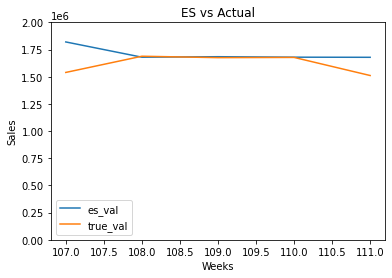

In [50]:
weeks = [107, 108, 109, 110, 111]
plt.plot(weeks, es_val)
plt.plot(weeks, true_val)
plt.ylim(0, 2000000)
plt.title('ES vs Actual')
plt.xlabel('Weeks')
plt.ylabel('Sales')
plt.legend(['es_val', 'true_val']);

Exponential smoothing with this data gives a mean absolute percent deviation of about 5.8% which is very close, but slightly worse than the simple moving average at 5.7%. If we ran the model on more data these numbers may change.

## 7. Adjusted Exponential Smoothing<a name='adj_es'></a>

This method takes finds a trend factor to adjust the values from exponential smoothing forcast. The smoothing constant for the trend will be 0.15. We will only do this for weeks 108 to 111 since the first forecast value depends on calculations for 107 exponential smoothing forecast

### 7.1. Define a Formula for Adjusted Exponential Smoothing Function:<a name='def_adj_es'></a>

In [51]:
def adj_es_tf(es_week_sale_1, es_week_sale_2, previous_trend_factor):
    return 0.85*(es_week_sale_2 - es_week_sale_1) + 0.15*previous_trend_factor

In [52]:
def adj_es(es_week_sale_2, current_trend_factor):
    return es_week_sale_2 + current_trend_factor

### 7.2. Adjusted Exponential Smoothing Forecast for Weeks 107 to 111:<a name='adj_es_forecast'></a>

In [53]:
trend_factor_108 = adj_es_tf(es_week_107_sales, es_week_108_sales, 0)
print(trend_factor_108)

-119204.92224999996


In [54]:
adj_es_week_108_sales = adj_es(es_week_108_sales, trend_factor_108)
print(adj_es_week_108_sales)

1560423.99275


In [55]:
trend_factor_109 = adj_es_tf(es_week_108_sales, es_week_109_sales, trend_factor_108)
print(trend_factor_109)

-14144.204212500103


In [56]:
adj_es_week_109_sales = adj_es(es_week_109_sales, trend_factor_109)
print(adj_es_week_109_sales)

1669880.6332875


In [57]:
trend_factor_110 = adj_es_tf(es_week_109_sales, es_week_110_sales, trend_factor_109)
print(trend_factor_110)

-5773.94356937511


In [58]:
adj_es_week_110_sales = adj_es(es_week_110_sales, trend_factor_110)
print(adj_es_week_110_sales)

1673954.0551806246


In [59]:
trend_factor_111 = adj_es_tf(es_week_110_sales, es_week_111_sales, trend_factor_110)
print(trend_factor_111)

-1824.5595041562665


In [60]:
adj_es_week_111_sales = adj_es(es_week_111_sales, trend_factor_111)
print(adj_es_week_111_sales)

1676775.8298708436


In [61]:
adj_es_val = [adj_es_week_108_sales, adj_es_week_109_sales, adj_es_week_110_sales, adj_es_week_111_sales]

In [62]:
adj_es_mapd = mapd(true_val[1:], adj_es_val)
print(adj_es_mapd)

0.04620812415869859


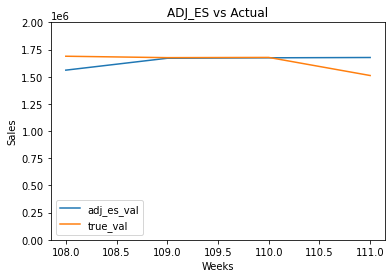

In [63]:
weeks = [108, 109, 110, 111]
plt.plot(weeks, adj_es_val)
plt.plot(weeks, true_val[1:])
plt.ylim(0, 2000000)
plt.title('ADJ_ES vs Actual')
plt.xlabel('Weeks')
plt.ylabel('Sales')
plt.legend(['adj_es_val', 'true_val']);

Adjusted exponential smoothing model for this data produces the lowest mean absolute percent deviation at about 4.6% which means it out performs all the other models thus far on this paticular set of data.

## 8. Summary<a name='sum'></a>

During the course of this notebook we have explored sales data and performed some simple forecasting methods commonly used in business. Out of the methods we have employed it appears that adjusted exponential smoothing performed the best, although weighted moving average could have been adjusted to perhaps improve lower its MAPD score further. <br>

There are more advanced forecasting techniques that could be applied here to make better use of the data such as SARIMA or if we want to use machine learning we could use XGBOOST. These methods are much more complicated and are outside the scope of this notebook, although I may create a notebook in the future to explore how effective these are. 